In [58]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, train, fit_rocket, fit_classifier
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff
### TODO: remove
from temp import find_best

subject_id = 5

eeg_data_1 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

In [59]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([#eeg_data_1, 
                      eeg_data_2, 
                      #eeg_data_3
                     ], ignore_index=True)
gradcpt_data = pd.concat([#gradcpt_data_1, 
                          gradcpt_data_2,
                          #gradcpt_data_3
                         ], ignore_index=True)

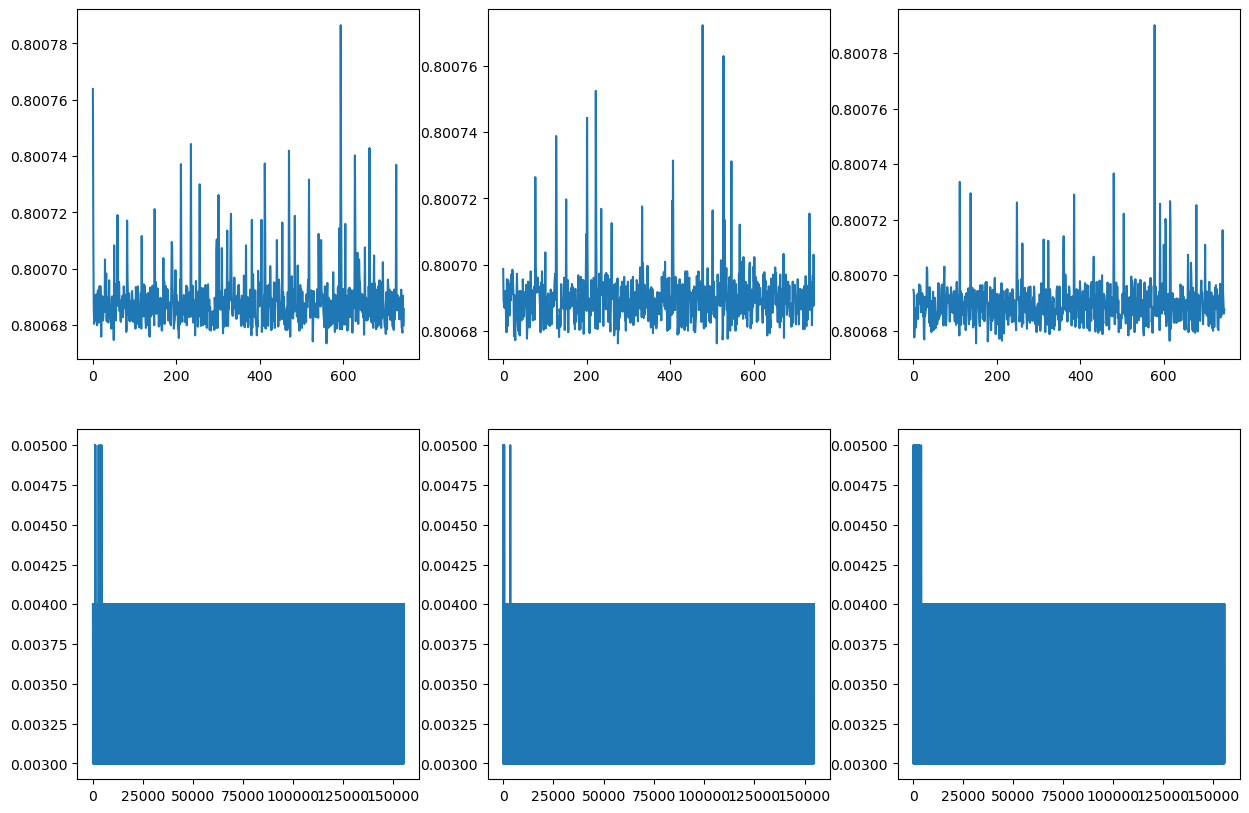

In [60]:
eeg_trials = [eeg_data_1, eeg_data_2, eeg_data_3]
gradcpt_trials = [gradcpt_data_1, gradcpt_data_2, gradcpt_data_3]
plot_sample_durations(eeg_trials, gradcpt_trials)

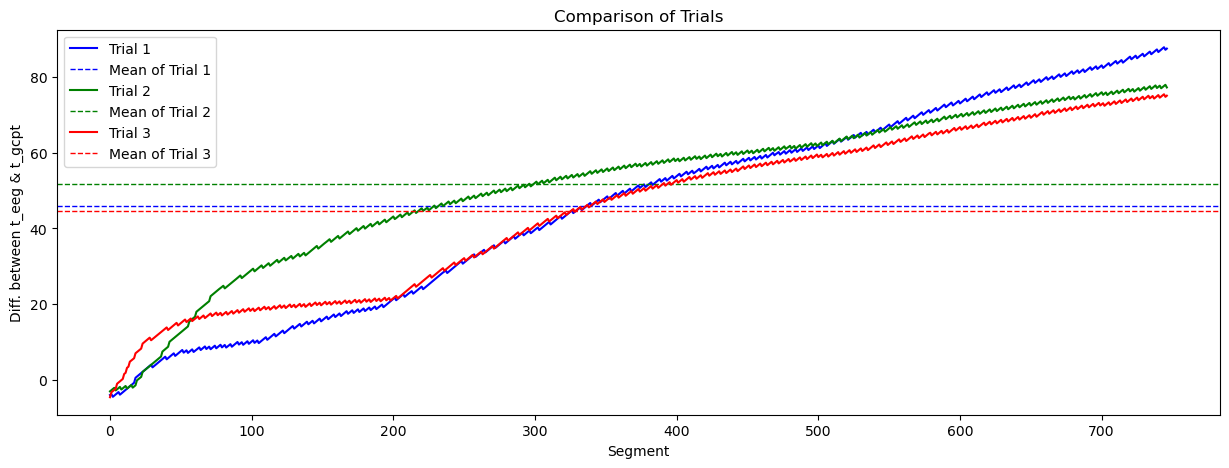

In [61]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### z-normalization

In [62]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [63]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [64]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

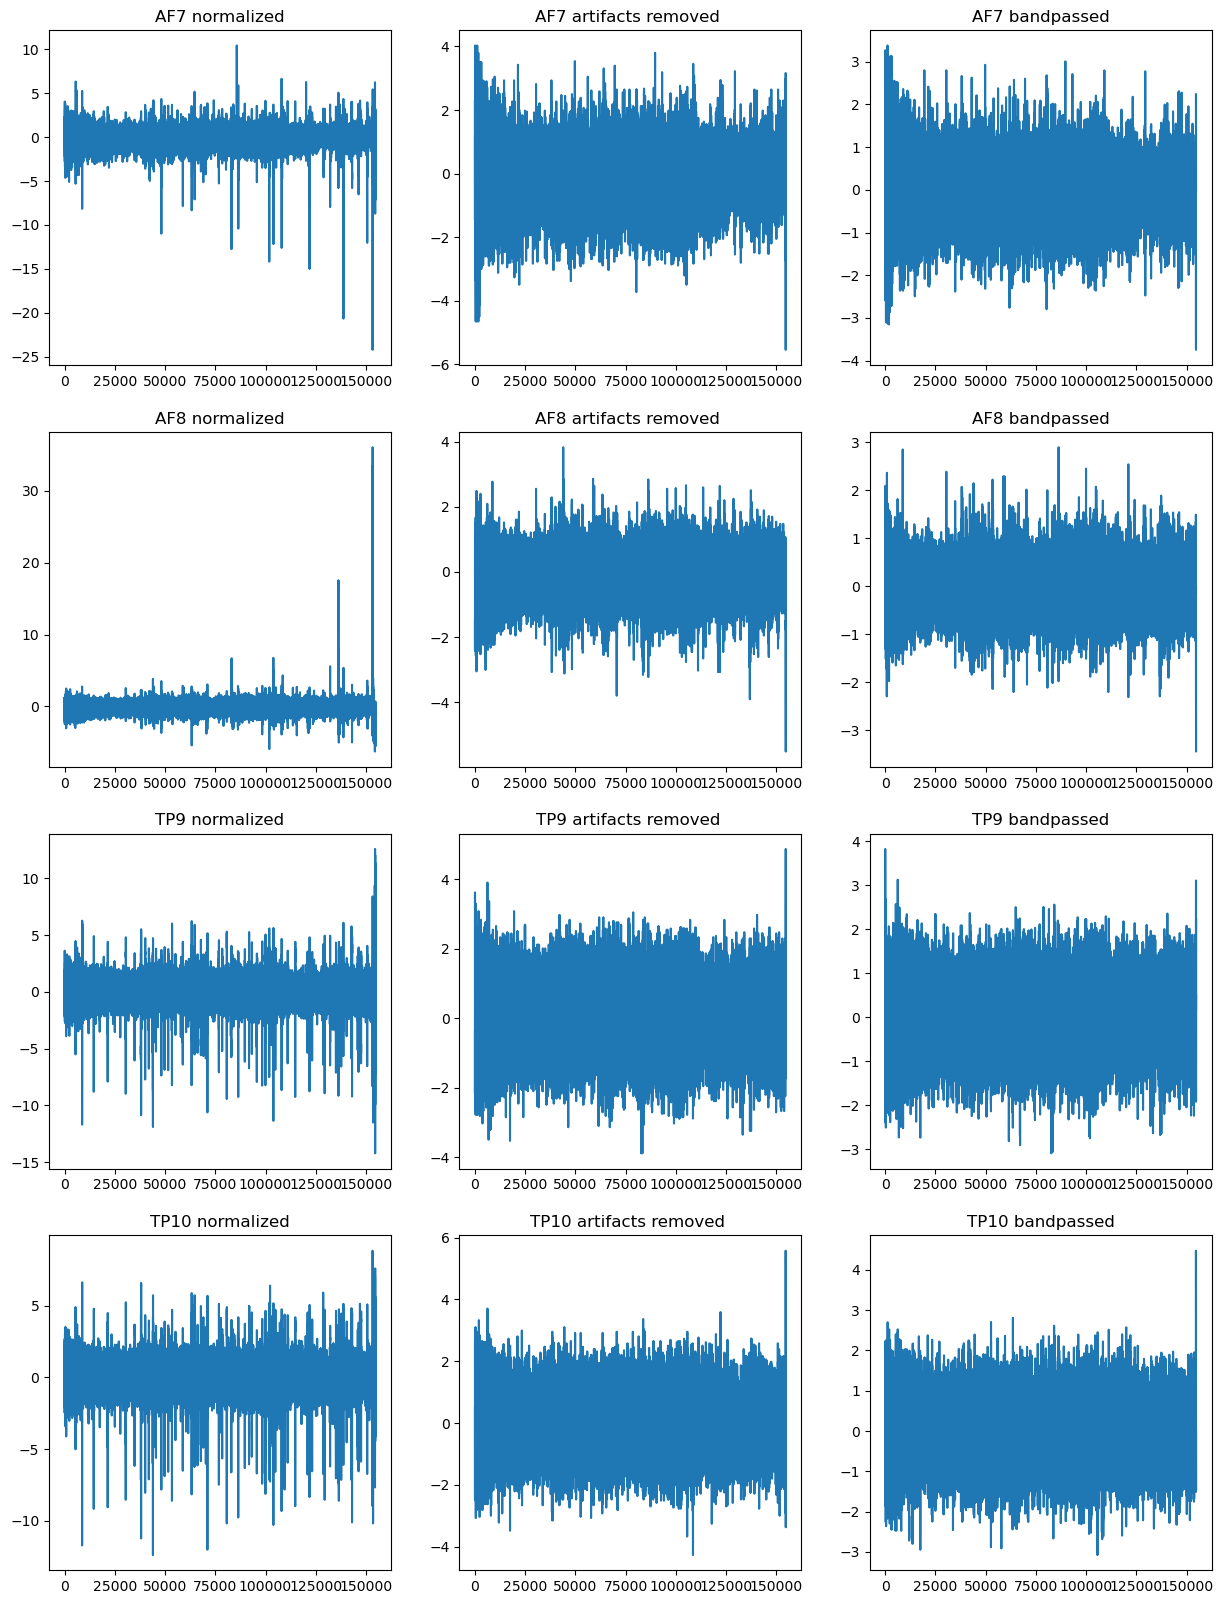

In [65]:
plot_preprocessing(channels=channels, eeg_df=eeg_data)

### Segment

In [66]:
all_channel_segments = []

# Process each channel
for channel in channels:
    # Segment the current EEG data for the channel
    channel_segments = segment_column(eeg_data[f'{channel}_bandpassed'], gradcpt_data)
    
    # Convert the list of segments into a numpy array with shape (number of segments, 205)
    # Not introducing the singleton dimension this time
    channel_segments_array = np.array(channel_segments).reshape(-1, 205)
    
    # Append the reshaped segments for this channel to the list
    all_channel_segments.append(channel_segments_array)

# Stack the channel segments along a new axis to combine them
# This should result in a shape: (number of segments, number of channels, 205)
combined_segments = np.stack(all_channel_segments, axis=1)
labels = np.array(gradcpt_data['in_the_zone'])

print(f"Corrected combined segments shape: {combined_segments.shape}")
print(f"Labels shape: {labels.shape}")

Corrected combined segments shape: (747, 4, 205)
Labels shape: (747,)


## Detach-ROCKET

### Combined features

In [67]:
X = combined_segments
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_af7, X_test_af7 = X_train[:,0:1,:], X_test[:,0:1,:]
X_train_af8, X_test_af8 = X_train[:,1:2,:], X_test[:,1:2,:]
X_train_tp9, X_test_tp9 = X_train[:,2:3,:], X_test[:,2:3,:]
X_train_tp10, X_test_tp10 = X_train[:,3:4,:], X_test[:,3:4,:]

In [68]:
model_combined_features = fit_rocket(X_train, X_test, y_train, y_test, trade_off=0.1 ,graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 77.76%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 66.00
Train Accuraccy Detach Model: 89.12%
-------------------------
Test Accuraccy Full Model: 59.29%
Test Accuraccy Detach-ROCKET: 46.02%
-------------------------
Optimal Model Size: 3.38% of full model


In [69]:
X_train_transformed = model_combined_features.transform_features(X_train)
X_test_transformed = model_combined_features.transform_features(X_test)

In [70]:
fit_classifier(X_train_transformed, X_test_transformed, y_train, y_test);

Training Accuracy:
0.831230283911672
Testing Accuracy:
0.5221238938053098

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.53      0.38      0.44        56
           1       0.52      0.67      0.58        57

    accuracy                           0.52       113
   macro avg       0.52      0.52      0.51       113
weighted avg       0.52      0.52      0.51       113


Confusion Matrix (Test):
 [[21 35]
 [19 38]]


In [71]:
find_best(X_train, X_test, y_train, y_test);

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 80.44%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 129.00
Train Accuraccy Detach Model: 62.15%
-------------------------
######################
######################
new best at p=0.01
Training Accuracy:
0.6246056782334385
Testing Accuracy:
0.5132743362831859

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.51      0.48      0.50        56
           1       0.52      0.54      0.53        57

    accuracy                           0.51       113
   macro avg       0.51      0.51      0.51       113
weighted avg       0.51      0.51      0.51       113


Confusion Matrix (Test):
 [[27 29]
 [26 31]]
######################
######################
TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 79.65%
-------------------------
TRAINING RESULTS Detach 

## Separate channels

### AF7

In [57]:
model_af7 = fit_rocket(X_train_af7, X_test_af7, y_train, y_test, graphic=False)

KeyboardInterrupt: 

In [ ]:
X_train_transformed_af7 = model_af7.transform_features(X_train_af7)
X_test_transformed_af7 = model_af7.transform_features(X_test_af7)

In [ ]:
fit_classifier(X_train_transformed_af7, X_test_transformed_af7, y_train, y_test);

### AF8

In [ ]:
model_af8 = fit_rocket(X_train_af8, X_test_af8, y_train, y_test, graphic=False)

In [ ]:
X_train_transformed_af8 = model_af8.transform_features(X_train_af8)
X_test_transformed_af8 = model_af8.transform_features(X_test_af8)

In [ ]:
fit_classifier(X_train_transformed_af8, X_test_transformed_af8, y_train, y_test);

### TP9

In [ ]:
model_tp9 = fit_rocket(X_train_tp9, X_test_tp9, y_train, y_test, graphic=False)

In [ ]:
X_train_transformed_tp9 = model_tp9.transform_features(X_train_tp9)
X_test_transformed_tp9 = model_tp9.transform_features(X_test_tp9)

In [ ]:
fit_classifier(X_train_transformed_tp9, X_test_transformed_tp9, y_train, y_test);

### TP10

In [ ]:
model_tp10 = fit_rocket(X_train_tp10, X_test_tp10, y_train, y_test, graphic=False)

In [ ]:
X_train_transformed_tp10 = model_tp10.transform_features(X_train_tp10)
X_test_transformed_tp10 = model_tp10.transform_features(X_test_tp10)

In [ ]:
fit_classifier(X_train_transformed_tp10, X_test_transformed_tp10, y_train, y_test);

### stacked

In [ ]:
X_train_transformed_stacked = np.hstack((X_train_transformed_af7, X_train_transformed_af8, X_train_transformed_tp9, X_train_transformed_tp10))
X_test_transformed_stacked = np.hstack((X_test_transformed_af7, X_test_transformed_af8, X_test_transformed_tp9, X_test_transformed_tp10))

In [ ]:
fit_classifier(X_train_transformed_stacked, X_test_transformed_stacked, y_train, y_test);